## Qiskit ADAPT-VQE tutorial

### Define the molecule
We start by defining the molecule using ``pyscf``. As an example we select the $H_2$ molecule and build it by providing its geometry.
This part of the code is based on ``Example_Molecules.ipynb`` jupyter notebook found at https://learning.quantum.ibm.com/course/quantum-chemistry-with-vqe/.

In [1]:
from pyscf import ao2mo, gto, mcscf, scf

distance = 0.735
a = distance / 2
mol = gto.Mole()
mol.build(
        verbose=0,
        atom=[
            ["H", (0, 0, -a)],
            ["H", (0, 0, a)],
        ],
        basis="sto-6g",
        spin=0,
        charge=0,
        symmetry="Dooh",
    )

In [2]:
print(f"Nuclear energy: {mol.energy_nuc()}")
print(f"Electronic energy: {mol.energy_elec()[0]}")
print(f"Total energy: {mol.energy_tot()}")
print(f"Total energy - nuclear energy: {mol.energy_tot() - mol.energy_nuc()}")

Nuclear energy: 0.7199689944489797
Electronic energy: -1.8455976628764188
Total energy: -1.125628668427439
Total energy - nuclear energy: -1.8455976628764188


/opt/anaconda3/envs/quantum/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
active_space = range(mol.nelectron // 2 - 1, mol.nelectron // 2 + 1)
print(active_space)

range(0, 2)


### Generate the fermionic Hamiltonian
We generate the fermionic Hamiltonian consisting of creation and annihilation operators. Single-electron (h1e) and double-electron (h2e) operators are extracted below.

In [4]:
mf = scf.RHF(mol)
E1 = mf.kernel()
mx = mcscf.CASCI(mf, ncas=2, nelecas=(1, 1))
mo = mx.sort_mo(active_space, base=0)
E2 = mx.kernel(mo)[:2]

In [5]:
h1e, ecore = mx.get_h1eff()
h2e = ao2mo.restore(1, mx.get_h2eff(), mx.ncas)

### Map the fermionic Hamiltonian to a qubit operator
Now, we map the fermionic Hamiltonian to a qubit Hamiltonian using the Jordan-Wigner transformation. Here, we implement the Jordan-Wigner mapper directly using only ``PySCF``, ``numpy``, and ``Qiskit``, as implemented in https://learning.quantum.ibm.com/course/quantum-chemistry-with-vqe/the-hamiltonian.

In [6]:
#------------Loading packages and defining necessary functions for mapping the fermionic Hamiltonian to one usable on IBM Quantum Systems---------------------

import numpy as np
from qiskit.quantum_info import SparsePauliOp


def cholesky(V, eps):
    # see https://arxiv.org/pdf/1711.02242.pdf section B2
    # see https://arxiv.org/abs/1808.02625
    # see https://arxiv.org/abs/2104.08957
    no = V.shape[0]
    chmax, ng = 20 * no, 0
    W = V.reshape(no**2, no**2)
    L = np.zeros((no**2, chmax))
    Dmax = np.diagonal(W).copy()
    nu_max = np.argmax(Dmax)
    vmax = Dmax[nu_max]
    while vmax > eps:
        L[:, ng] = W[:, nu_max]
        if ng > 0:
            L[:, ng] -= np.dot(L[:, 0:ng], (L.T)[0:ng, nu_max])
        L[:, ng] /= np.sqrt(vmax)
        Dmax[: no**2] -= L[: no**2, ng] ** 2
        ng += 1
        nu_max = np.argmax(Dmax)
        vmax = Dmax[nu_max]
    L = L[:, :ng].reshape((no, no, ng))
    print(
        "accuracy of Cholesky decomposition ",
        np.abs(np.einsum("prg,qsg->prqs", L, L) - V).max(),
    )
    return L, ng


def identity(n):
    return SparsePauliOp.from_list([("I" * n, 1)])


def creators_destructors(n, mapping="jordan_wigner"):
    c_list = []
    if mapping == "jordan_wigner":
        for p in range(n):
            if p == 0:
                l, r = "I" * (n - 1), ""
            elif p == n - 1:
                l, r = "", "Z" * (n - 1)
            else:
                l, r = "I" * (n - p - 1), "Z" * p
            cp = SparsePauliOp.from_list([(l + "X" + r, 0.5), (l + "Y" + r, 0.5j)])
            c_list.append(cp)
    else:
        raise ValueError("Unsupported mapping.")
    d_list = [cp.adjoint() for cp in c_list]
    return c_list, d_list


def build_hamiltonian(ecore: float, h1e: np.ndarray, h2e: np.ndarray) -> SparsePauliOp:
    ncas, _ = h1e.shape

    C, D = creators_destructors(2 * ncas, mapping="jordan_wigner")
    Exc = []
    for p in range(ncas):
        Excp = [C[p] @ D[p] + C[ncas + p] @ D[ncas + p]]
        for r in range(p + 1, ncas):
            Excp.append(
                C[p] @ D[r]
                + C[ncas + p] @ D[ncas + r]
                + C[r] @ D[p]
                + C[ncas + r] @ D[ncas + p]
            )
        Exc.append(Excp)

    # low-rank decomposition of the Hamiltonian
    Lop, ng = cholesky(h2e, 1e-6)
    t1e = h1e - 0.5 * np.einsum("pxxr->pr", h2e)

    H = ecore * identity(2 * ncas)
    # one-body term
    for p in range(ncas):
        for r in range(p, ncas):
            H += t1e[p, r] * Exc[p][r - p]
    # two-body term
    for g in range(ng):
        Lg = 0 * identity(2 * ncas)
        for p in range(ncas):
            for r in range(p, ncas):
                Lg += Lop[p, r, g] * Exc[p][r - p]
        H += 0.5 * Lg @ Lg

    return H.chop().simplify()

In [7]:
H = build_hamiltonian(ecore, h1e, h2e)
print(H)

accuracy of Cholesky decomposition  6.655392125243921e-17
SparsePauliOp(['IIII', 'IIIZ', 'IZII', 'IIZI', 'ZIII', 'IZIZ', 'IIZZ', 'ZIIZ', 'IZZI', 'ZZII', 'ZIZI', 'YYYY', 'XXYY', 'YYXX', 'XXXX'],
              coeffs=[-0.09820182+0.j, -0.1740751 +0.j, -0.1740751 +0.j,  0.2242933 +0.j,
  0.2242933 +0.j,  0.16891402+0.j,  0.1210099 +0.j,  0.16631441+0.j,
  0.16631441+0.j,  0.1210099 +0.j,  0.17504456+0.j,  0.04530451+0.j,
  0.04530451+0.j,  0.04530451+0.j,  0.04530451+0.j])


### Remark
Compare with the exact ground state energy below. There is a mismatch with this and the pyscf computed energies.

In [9]:
from qiskit_algorithms import NumPyMinimumEigensolver

exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(H)
print(exact_result.eigenvalue)

-1.1459778538543868


### Outline of the ADAPT-VQE algorithm
https://arxiv.org/abs/1812.11173 

1. Initiate the quantum computer in the Hartree-Fock state. In Jordan-Wigner transformation, this has a bitstring representation implemented with $X$-gates.

2. Define the pool of operators as the set of excitation operators generated by the UCC ansatz. Note that under the Jordan-Wigner transformation, these operators are anti-Hermitian. 

3. Define the following conditions for termination: CONVERGED, CYCLICITY, MAXIMUM.
    - CONVERGED: Gradient of all operators from the pool are smaller than some threshold.
    - CYCLICITY: Aborted due to a cyclic selection of evolution operators.
    - MAXIMUM: Maximum number of iterations reached.
    
4. while not TERMINATE (CONVERGED or CYCLICITY or MAXIMUM):
    - Compute the gradient of each operator from the pool and select the operator with the maximum gradient
    - Append the ansatz with $\textrm{exp}(j*\theta_i*\textrm{operator}_i)$
    - Run VQE over all parameters $\theta_i$

### Initial state
We initate the quantum computer to the Hartree-Fock state.

In [11]:
def hartree_fock_bitstring(num_spatial_orbitals: int, num_particles: tuple[int, int]) -> list[bool]:
    """Compute the bitstring representing the Hartree-Fock state for the specified system.

    Args:
        num_spatial_orbitals: The number of spatial orbitals, has a min. value of 1.
        num_particles: The number of particles as a tuple storing the number of alpha- and beta-spin
                       electrons in the first and second number, respectively.

    Returns:
        The bitstring representing the state of the Hartree-Fock state as array of bools.

    Raises:
        ValueError: If the total number of particles is larger than the number of orbitals.
    """
    # validate the input
    assert num_spatial_orbitals >= 1
    num_alpha, num_beta = num_particles

    if any(n > num_spatial_orbitals for n in num_particles):
        raise ValueError("# of particles must be less than or equal to # of orbitals.")

    half_orbitals = num_spatial_orbitals
    bitstr = np.zeros(2 * num_spatial_orbitals, bool)
    bitstr[:num_alpha] = True
    bitstr[half_orbitals : (half_orbitals + num_beta)] = True

    return bitstr.tolist()

We build the circuit preparing the Hartree-Fock state in Jordan-Wigner transform.

/opt/anaconda3/envs/quantum/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


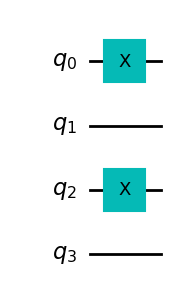

In [12]:
from qiskit import QuantumCircuit

num_spatial_orbitals = mx.ncas
num_particles = mol.nelec

# Get the Hartree-Fock initial state in bitsting representation
hf_bitstring = hartree_fock_bitstring(num_spatial_orbitals, num_particles)

# Get the corresponding circuit in Jordan-Wigner transform
hf_circuit = QuantumCircuit(len(hf_bitstring))
for i, hf_bit in enumerate(hf_bitstring):
    if hf_bit:
        hf_circuit.x(i)

hf_circuit.draw(output = 'mpl')

### Operator pool
We define the set of operators as the single and double excitation operators generated by the UCC ansatz. These operators are also represented under the Jordan-Wigner transform. Note that this results in anti-Hermitian excitation operators, but we omit the complex phase 1j for simplicity. Therefore, they appear Hermitian.

In [13]:
from qiskit_nature.second_q.circuit.library.ansatzes import UCC
from qiskit_nature.second_q.mappers import JordanWignerMapper

qubit_mapper = JordanWignerMapper()

# Define the pool of operators as those generated by the UCC ansatz
ucc = UCC(num_spatial_orbitals, num_particles, 'sd', qubit_mapper)
excitation_pool = ucc.operators  # TODO
print(excitation_pool)

[SparsePauliOp(['IIXY', 'IIYX'],
              coeffs=[ 0.5+0.j, -0.5+0.j]), SparsePauliOp(['XYII', 'YXII'],
              coeffs=[ 0.5+0.j, -0.5+0.j]), SparsePauliOp(['YYXY', 'XYYY', 'XXXY', 'YXYY', 'XYXX', 'YYYX', 'YXXX', 'XXYX'],
              coeffs=[-0.125+0.j, -0.125+0.j, -0.125+0.j,  0.125+0.j, -0.125+0.j,  0.125+0.j,
  0.125+0.j,  0.125+0.j])]


### Gradient of the excitation operators
We compute the gradient of all excitation operators in the pool given the current optimized ansatz. Note that the following computation requires the operators from the pool to be anti-Hermitian, and should be replaced with an appropriate alternative method if this is not the case.

In [16]:
def compute_gradients(ansatz, hamiltonian, excitation_pool, estimator, params=None):
    """
    Computes the gradients for all available excitation operators.
    Args:
        ansatz: ansatz built so far.
        hamiltonian: Hamiltonian after qubit mapping in SparsePauliOp format.
        excitation_pool: anti-Hermitian operators whose gradients need to be computed.
        estimator: an instance of the Qiskit Estimator primitive
        params: parameters to be assigned to the ansatz, if any.
    Returns:
        List of computed gradients in the same order as the excitation operators in the excitation pool.
    """
    # The excitations operators are applied later as exp(i*theta*excitation).
    # For this commutator, we need to explicitly pull in the imaginary phase.
    if params is not None:
        ansatz_opt = ansatz.assign_parameters(params)
    else:
        ansatz_opt = ansatz
    # We recall that 1j was omitted earlier for the anti-Hermitian operators.
    commutators = [1j * (hamiltonian @ exc - exc @ hamiltonian) for exc in excitation_pool]
    ansatz_list = [ansatz_opt for _ in range(len(commutators))]
    gradients = estimator.run(ansatz_list, commutators).result().values

    return gradients

Let's grow the ansatz step by step by before putting the code into a loop. First, our ansatz is simply the Hartree-Fock initial state. Now we will compute the gradient of each operator in the excitation pool and select the operator with the largest gradient to append to our current ansatz with a corresponding variational parameter. For now, we use an exact simulator by defining the options of the Qiskit Estimator primitive.

In [19]:
import numpy as np
from qiskit.primitives import Estimator

ansatz = hf_circuit
hamiltonian = H
estimator = Estimator(options={"shots": None, "approximation": True})

gradients = compute_gradients(ansatz, hamiltonian, excitation_pool, estimator)
print(gradients)

max_gradient = np.max(np.abs(gradients))
max_index = np.argmax(np.abs(gradients))
max_operator = excitation_pool[max_index]
print(f"Found operator {max_operator} with maximum gradient {max_gradient} at index {max_index}.")

[ 0.          0.         -0.36243609]
Found operator SparsePauliOp(['YYXY', 'XYYY', 'XXXY', 'YXYY', 'XYXX', 'YYYX', 'YXXX', 'XXYX'],
              coeffs=[-0.125+0.j, -0.125+0.j, -0.125+0.j,  0.125+0.j, -0.125+0.j,  0.125+0.j,
  0.125+0.j,  0.125+0.j]) with maximum gradient 0.362436085015165 at index 2.


### Expand the Ansatz
We found that the third operator in the pool, which is the double-excitation operator in this case, has the largest gradient magnitude. Therefore, we will now append it to the ansatz as $\textrm{exp}(i*\theta_0*\textrm{max\_operator})$, where $\theta_0$ is the corresponding time evolution parameter. This will be our variational parameter to be optimized in the VQE step. Now we can easily time-evolve the selected operator by using the ``EvolvedOperatorAnsatz`` from Qiskit. Note that the operator to be complex exponentiated and evolved consists of summed Pauli operators. Therefore, the evolution parameter of this ansatz class can be specified to run with different methods such as ``LieTrotter``, ``SuzukiTrotter``, or exactly with ``MatrixExponential`` for small problems.

/opt/anaconda3/envs/quantum/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


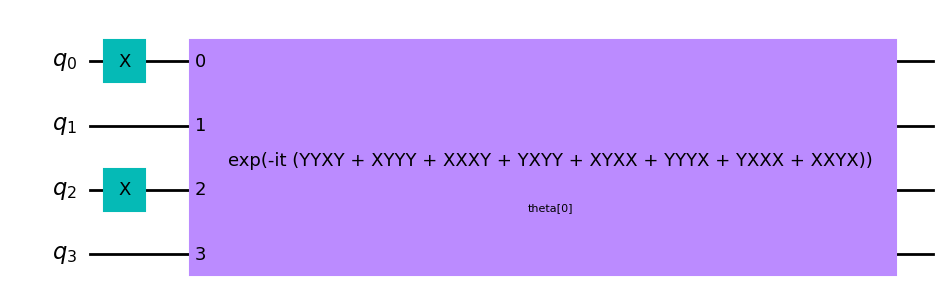

In [20]:
from qiskit.circuit.library import EvolvedOperatorAnsatz
from qiskit.synthesis import MatrixExponential, SuzukiTrotter, LieTrotter

ansatz = EvolvedOperatorAnsatz(operators=max_operator, evolution=MatrixExponential(), parameter_prefix='theta', initial_state=hf_circuit)
ansatz.decompose().draw(output = 'mpl')

Note that adding an operator to the ansatz does not drain the pool, i.e. the operator we added can again be selected in another iteration.

### Run VQE
We are now ready to run a full VQE on the ansatz that we have so far. We define the cost function as the expectation of the Hamiltonian as usual, and set up the Estimator primitive and randomly initiate the parameters to be optimized.

In [21]:
def cost_func(params, ansatz, H, estimator):
    energy = estimator.run(ansatz, H, parameter_values=params).result().values[0]
    return energy

In [22]:
from qiskit.primitives import Estimator

estimator = Estimator(options={"shots": None, "approximation": True})

In [24]:
# Random start for the ansatz parameters
x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
print(x0)

[3.44440489]


Now we classically optimize the $\theta_0$ parameter of our ansatz using the ``minimize`` function from ``scipy``.

In [28]:
from scipy.optimize import minimize

res = minimize(cost_func, x0, args=(ansatz, H, estimator), method="cobyla", options={'maxiter': 50, 'disp': True})
print(res)

# Note this returns the total energy, and we are often interested in the electronic energy
ground_energy = getattr(res, 'fun')
print(f"Found ground energy: {ground_energy}, exact energy: {exact_result.eigenvalue}, difference: {ground_energy - exact_result.eigenvalue}")

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.1459778287234819
       x: [ 4.824e+00]
    nfev: 22
   maxcv: 0.0
   Normal return from subroutine COBYLA

Found ground energy: -1.1459778287234819, exact energy: -1.1459778538543868, difference: 2.513090491262915e-08

   NFVALS =   22   F =-1.145978E+00    MAXCV = 0.000000E+00
   X = 4.824088E+00


NOTE: The ground state energy went below the exact value computed by ``pyscf``. This numerical error is due to the approximation error in the simulation of the EvolvedOperatorAnsatz evolution (LieTrotter in this case).

In [29]:
# Optimal parameters so far
x_opt =  getattr(res, 'x')
print(x_opt)

[4.82408771]


### Another iteration of the algorithm
We now compute the gradients again to see if we need another iteration.

In [30]:
gradient_threshold = 1e-3

gradients = compute_gradients(ansatz, hamiltonian, excitation_pool, estimator, params=x_opt)
print(gradients)

max_gradient = np.max(np.abs(gradients))
max_index = np.argmax(np.abs(gradients))

print(f"Found maximum gradient {max_gradient} at index {max_index}")
print(f"Maximum gradient is below the threshold: {max_gradient < gradient_threshold}")

[0.         0.         0.00040531]
Found maximum gradient 0.00040530591672278266 at index 2
Maximum gradient is below the threshold: True


Since the maximum gradient is below the threshold, we do not append another operator to the ansatz, and the algorithm terminates.

### Putting it all together
Now we automate the algorithm in a single loop.

In [34]:
# Define the conditions for termination
gradient_threshold = 1e-3
max_iter = 10
terminate = False

# Initiate the problem
ansatz = hf_circuit
hamiltonian = H
excitation_pool = ucc.operators  # TODO
estimator = Estimator(options={"shots": None, "approximation": True})
params = None

iter = 0
operator_list = []
while not terminate:
    gradients = compute_gradients(ansatz, hamiltonian, excitation_pool, estimator, params)
    max_gradient = np.max(np.abs(gradients))
    # Check convergence
    if max_gradient > gradient_threshold:
        # Find the operator with the largest gradient
        max_index = np.argmax(np.abs(gradients))
        max_operator = excitation_pool[max_index]
        # Grow the ansatz
        operator_list.append(max_operator)
        ansatz = EvolvedOperatorAnsatz(operators=operator_list, evolution=LieTrotter(), parameter_prefix='theta', initial_state=hf_circuit) 
        # Run VQE on the current ansatz
        x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
        res = minimize(cost_func, x0, args=(ansatz, H, estimator), method="cobyla", options={'maxiter': 50, 'disp': True})
        x_opt =  getattr(res, 'x')
        params = x_opt
        # Terminate if maximum number of iterations reached
        iter += 1
        if iter >= max_iter:
            terminate = True
    # Terminate if converged
    else:
        terminate = True
    
# Note this returns the total energy, and we are often interested in the electronic energy
ground_energy = getattr(res, 'fun')
print(f"Found ground energy: {ground_energy}, exact energy: {exact_result.eigenvalue}, difference: {ground_energy - exact_result.eigenvalue}")


   Normal return from subroutine COBYLA

   NFVALS =   24   F =-1.145978E+00    MAXCV = 0.000000E+00
   X = 4.824100E+00
Found ground energy: -1.14597783349519, exact energy: -1.1459778538543868, difference: 2.03591967729011e-08
